In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy import ndimage, misc
import cv2
from skimage.morphology import skeletonize
from sklearn import linear_model
from sklearn import model_selection 
import gc
gc.collect()

32

In [2]:
def line_prepender(filename, line):
    with open(filename, 'r+') as f:
        content = f.read()
        f.seek(0, 0)
        f.write(line.rstrip('\r\n') + '\n' + content)

In [3]:
def convert_to_cad(pattern_len, cx, cy):
    res=np.zeros([np.shape(cx)[0]*2,2])
    for k in range(np.shape(cx)[0]):
    
        res[2*k]=[cx[k]-pattern_len/2+1, cy[k]-pattern_len/2+1]
        res[2*k+1]=[cx[k]+pattern_len/2+1, cy[k]+pattern_len/2+1]
        
    return res

In [7]:
def generate_pattern(pattern_dim, threshold):
    random_pattern = np.random.rand(pattern_dim, pattern_dim)
    binary_pattern = np.where(random_pattern < threshold, 1, 0)
    
    org_locs = np.where(binary_pattern == 1)
    
    return org_locs, binary_pattern

In [8]:
def transform_to_image(binary, pattern_len, spacing, pattern_dim, edge):
    
    
    res1_lo = np.argwhere(binary == 1)
   
    scale=pattern_len+spacing
    res1 = np.array([np.array([yi*scale, xi*scale])+edge for yi, xi in res1_lo])
    

    im = np.zeros((pattern_dim*scale+edge , pattern_dim*scale+edge))
    for k in range(res1.shape[0]):
        y, x = res1[k][0], res1[k][1]
        
        im[y:y+pattern_len,x:x+pattern_len] = 255

    return im

In [9]:
def extract_features(im, sigma):
   
    im_8=np.uint8(im)    
    #gray = cv2.cvtColor(im_8, cv2.COLOR_BGR2GRAY)
    # Find Canny edges
    edged = cv2.Canny(im_8, 30, 200)
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    centroid=np.zeros([np.shape(contours)[0],2])
    feats=np.zeros([np.shape(contours)[0],2])

    gc.collect()
    im_blur = ndimage.gaussian_filter(im, sigma=sigma, mode='constant',cval=0)
    im_blur_norm=im_blur*sigma*np.sqrt(np.pi)
    im_sx = ndimage.sobel(im_blur_norm, axis=1, mode='reflect')
    im_sy = ndimage.sobel(im_blur_norm, axis=0, mode='reflect')
    im_sobel=np.hypot(im_sx, im_sy)
        #im_lap = ndimage.laplace(im_blur_norm, mode='reflect')
    for jj in range(np.shape(contours)[0]):    
        gc.collect()
        im_zer = np.zeros( (im.shape[0],im.shape[1]) ) # create a single channel 200x200 pixel black image 
        filled_array = cv2.fillPoly(im_zer, pts =[contours[jj]], color=(255))
        obj = np.argwhere(filled_array == 255)


        density=np.nanmean(im_blur_norm[obj[:,0],obj[:,1]])
        grad=np.nanmean(im_sobel[obj[:,0],obj[:,1]])
        feats[jj]=np.array([grad, density])
            #lap[ii,jj]=np.nanmean(im_lap[obj[:,0],obj[:,1]])


            # find centroid
        M = cv2.moments(contours[jj])
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroid[jj]=np.array([cX,cY])
        
        
    return feats, centroid

In [7]:
def extract_features_2(im, sigma):
   
    im_8=np.uint8(im)    
    #gray = cv2.cvtColor(im_8, cv2.COLOR_BGR2GRAY)
    # Find Canny edges
    edged = cv2.Canny(im_8, 30, 200)
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    #centroid=np.zeros([np.shape(contours)[0],2])
    feats=np.zeros([np.shape(contours)[0],2])

    gc.collect()
    im_blur = ndimage.gaussian_filter(im, sigma=sigma, mode='constant',cval=0)
    im_blur_norm=im_blur*sigma*np.sqrt(np.pi)
    im_sx = ndimage.sobel(im_blur_norm, axis=1, mode='reflect')
    im_sy = ndimage.sobel(im_blur_norm, axis=0, mode='reflect')
    im_sobel=np.hypot(im_sx, im_sy)
        #im_lap = ndimage.laplace(im_blur_norm, mode='reflect')
    for jj in range(np.shape(contours)[0]):    
        gc.collect()
        im_zer = np.zeros( (im.shape[0],im.shape[1]) ) # create a single channel 200x200 pixel black image 
        filled_array = cv2.fillPoly(im_zer, pts =[contours[jj]], color=(255))
        obj = np.argwhere(filled_array == 255)


        density=np.nanmean(im_blur_norm[obj[:,0],obj[:,1]])
        grad=np.nanmean(im_sobel[obj[:,0],obj[:,1]])
        feats[jj]=np.array([grad, density])
            #lap[ii,jj]=np.nanmean(im_lap[obj[:,0],obj[:,1]])


            # find centroid
       # M = cv2.moments(contours[jj])
        #cX = int(M["m10"] / M["m00"])
        #cY = int(M["m01"] / M["m00"])
       # centroid[jj]=np.array([cX,cY])
        
        
    return feats#, centroid

In [10]:
def centroids_to_image(pattern_size, cx, cy, spacing, edge, pattern_dim):
    
    
    overlap = 0
    
    scale=pattern_size+spacing
    
    im = np.zeros((pattern_dim*scale+edge , pattern_dim*scale+edge))
    
    im_overlap=np.zeros((pattern_size*scale+edge , pattern_size*scale+edge))
    for k in range(cx.shape[0]):
        x, y = int(cx[k]), int(cy[k])
        
        space=int(pattern_size/2)
        im[x-space:x+space,y-space:y+space] = 255
        
        space_2=int(scale/2)
        im_overlap[x-space_2:x+space_2,y-space_2:y+space_2] = im_overlap[x-space_2:x+space_2,y-space_2:y+space_2] + 1
    if np.max(im_overlap)>1:
        
        overlap = 1
    
    return im, overlap
    

In [11]:
def mean_dipole_calculation(feats):
    dipole=2.27828701e-05*feats[:,1] + 3.47963462e-04*feats[:,0] -0.14675008803190104
    mean_dip=np.mean(dipole)
    min_dip=np.min(dipole)
    return mean_dip, min_dip

In [10]:
def second_smallest(numbers):
    m1 = m2 = float('inf')
    for x in numbers:
        if x <= m1:
            m1, m2 = x, m1
        elif x < m2:
            m2 = x
    return m2

In [11]:
def step(centroid, move_id,dx,dy):
    centroid_n = np.array(centroid)
    centroid_n[move_id,0] = centroid_n[move_id,0]+round(dx)
    centroid_n[move_id,1] = centroid_n[move_id,1]+round(dy)
    return centroid_n

In [17]:
def check_step(mean_dip_n, mean_dip, im_2, im_f, centroid_n, centroid, min_dip_n, min_dip):
    rand_n=np.random.randint(1000)
    
    if mean_dip_n > mean_dip and min_dip_n>=min_dip:
        print(mean_dip)
        centroid = np.array(centroid_n)
        mean_dip = np.array(mean_dip_n)
        min_dip = np.array(min_dip_n)
        im_f = np.array(im_2)
    else:
        centroid = centroid
        mean_dip = mean_dip
        im_f = im_f
        min_dip=min_dip
            
    return mean_dip, im_f, centroid, min_dip

## Simulated annealing

In [ ]:
# set image coeffs
grid_size=20
pattern_size=150
space_between=50
edge=100


# define sigma based on previous data
sigma=200
# generate 5x5 pattern
locs, binary = generate_pattern(grid_size, 0.1)
im  = transform_to_image(binary, pattern_size, space_between, grid_size, edge)
feats, centroid = extract_features(im, sigma)
mean_dip, min_dip = mean_dipole_calculation(feats)

im_f=im
for kk in range(100):
    
    # choose pattern to move
    move_id=np.random.randint(np.shape(centroid)[0])
    
    # move by a gaussian in both directions
    
    dx, dy = np.random.normal(0, 12, 2)
    
    # new centroid
    centroid_n = step(centroid, move_id, dx, dy)
    
    bound=grid_size*(pattern_size+space_between)-26
    #check that move doesn't overlap with other patterns
    centroid_n[centroid_n<174]=174
    centroid_n[centroid_n>bound]=bound
    
    im_2, overlap = centroids_to_image(pattern_size, centroid_n[:,1], centroid_n[:,0], space_between, edge, grid_size)
    
   # print(centroid-centroid_n)
    if overlap == 0:
        
        
        feats = extract_features_2(im_2, sigma)
    
        mean_dip_n, min_dip_n = mean_dipole_calculation(feats)
        
       
        mean_dip, im_f, centroid, min_dip = check_step(mean_dip_n, mean_dip, im_2, im_f, centroid_n, centroid, min_dip_n, min_dip)
       

plt.figure()
plt.imshow(im, plt.cm.gray)

plt.figure()
plt.imshow(im_f, plt.cm.gray)

0.15738344754567618


In [44]:
np.shape(np.zeros((200*20+100 , 200*20+100)))

(4100, 4100)

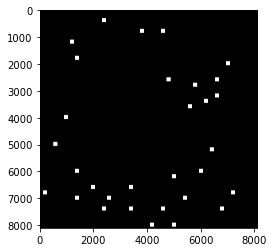

         0       1
0   4900.0  7900.0
1   5050.0  8050.0
2   4100.0  7900.0
3   4250.0  8050.0
4   6700.0  7300.0
..     ...     ...
57  4650.0   850.0
58  3700.0   700.0
59  3850.0   850.0
60  2300.0   300.0
61  2450.0   450.0

[62 rows x 2 columns]


In [145]:
locs, binary = generate_pattern(40,0.02)
im  = transform_to_image(binary,150,50,40,100)

plt.figure()
plt.imshow(im, plt.cm.gray)
plt.show()
sigma=400
feats, centroid = extract_features(im, sigma)
result = convert_to_cad (150, centroid[:,0], centroid[:,1])


#save to txt for cad
name="test.txt"
df = pd.DataFrame(data=result)
df.to_csv(name, index=False)

with open('test.txt', 'r') as fin:
    data = fin.read().splitlines(True)
with open('test.txt', 'w') as fout:
    fout.writelines(data[1:])
line_prepender("test.txt", 'Rectang')
line_prepender("test.txt", 'Multiple')

In [25]:
centroid

array([[3974., 3974.],
       [2769., 3966.],
       [2562., 3949.],
       [1174., 3974.],
       [ 974., 3974.],
       [3974., 3774.],
       [3145., 3762.],
       [2174., 3774.],
       [1974., 3774.],
       [ 593., 3782.],
       [2574., 3574.],
       [2174., 3574.],
       [1174., 3574.],
       [1574., 3374.],
       [ 954., 3390.],
       [1774., 3174.],
       [1574., 3174.],
       [ 574., 3159.],
       [ 374., 3174.],
       [ 174., 2992.],
       [3154., 2780.],
       [ 776., 2754.],
       [2374., 2574.],
       [1570., 2592.],
       [ 174., 2574.],
       [2565., 2370.],
       [ 945., 2391.],
       [2973., 2148.],
       [1976., 2174.],
       [ 384., 2190.],
       [3174., 1974.],
       [2175., 1964.],
       [1974., 1974.],
       [1974., 1774.],
       [1600., 1803.],
       [3974., 1586.],
       [2174., 1574.],
       [1974., 1374.],
       [ 974., 1374.],
       [ 974., 1174.],
       [2374.,  974.],
       [2174.,  974.],
       [3774.,  774.],
       [358

[[  284.7921751  14483.3218388 ]
 [  105.25012042 11748.26865992]
 [  293.94090691 14548.86595197]
 [  132.34164038 17633.5641353 ]
 [  140.51472596 18408.7911212 ]
 [  228.80982677 14473.06290555]
 [  165.17425454 17814.70753406]
 [  103.76549217 18057.02613103]
 [  243.55327819 13808.65484631]
 [  161.42009708 16647.43540937]
 [  302.33314552 12955.64948268]]


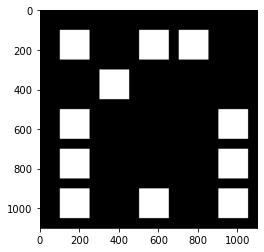

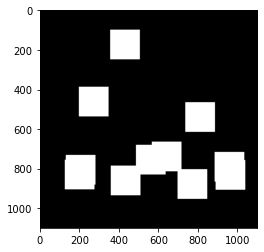

In [348]:
plt.figure()
plt.imshow(im, plt.cm.gray)
feats = extract_features_2(im, sigma)
    
mean_dip_n, min_dip_n = mean_dipole_calculation(feats)
im_f, overlap =centroids_to_image(150, centroid[:,1], centroid[:,0], 50, 100, 5)

plt.figure()
plt.imshow(im_f, plt.cm.gray)
centroid[centroid<174]=174
centroid[centroid>974]=974
print(feats)
#np.argwhere(centroid[:,:]<174)[0]

In [149]:
%cd C:\Users\heito\Desktop\Harvard\Sharad Lab\G1\Random_7 
df=np.load('match_7.npy')
print(df)

C:\Users\heito\Desktop\Harvard\Sharad Lab\G1\Random_7
[[3.90000000e+03 1.00000000e+02 2.01000000e+03 1.19000000e+02
  7.60000000e+01 2.88872386e-02]
 [3.10000000e+03 3.00000000e+02 1.67200000e+03 1.99000000e+02
  1.11000000e+02 1.65733172e-02]
 [4.50000000e+03 3.00000000e+02 2.33100000e+03 2.20000000e+02
  7.50000000e+01 1.79496984e-02]
 [2.50000000e+03 5.00000000e+02 1.25300000e+03 2.98000000e+02
  1.44000000e+02 2.58689363e-02]
 [5.70000000e+03 5.00000000e+02 2.97200000e+03 3.61000000e+02
  3.90000000e+01 2.17424963e-03]
 [6.30000000e+03 5.00000000e+02 3.31500000e+03 2.95000000e+02
  7.50000000e+01 2.17008011e-02]
 [1.10000000e+03 7.00000000e+02 5.70000000e+02 4.24000000e+02
  7.70000000e+01 2.49367802e-02]
 [4.50000000e+03 7.00000000e+02 2.33600000e+03 4.78000000e+02
  3.80000000e+01 3.38111463e-03]
 [5.10000000e+03 7.00000000e+02 2.61700000e+03 4.31000000e+02
  7.60000000e+01 2.80310439e-02]
 [5.30000000e+03 7.00000000e+02 2.77300000e+03 4.33000000e+02
  1.06000000e+02 4.22251845e-

C:\Users\heito\Desktop\Harvard\Sharad Lab\G1\paired


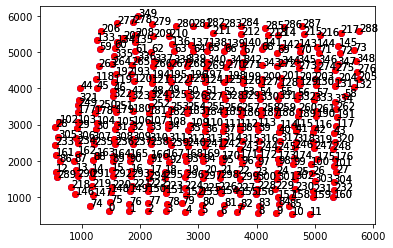

In [100]:
#match features and dipoles
%cd C:\Users\heito\Desktop\Harvard\Sharad Lab\G1\paired
df_table=pd.read_csv('dfPairedFilter.csv', delimiter=',')
#df_t=df_table.loc[df_table['seed'] == 12]
df=df_table.to_numpy()

match_table=pd.read_csv('dfPairedFull.csv', delimiter=',')
match=match_table.to_numpy()
#print(match)
new_metric=pd.read_csv('exported_metrics_paired_n.csv', delimiter=',')
arr=new_metric.to_numpy()
#print(arr)
df_new=np.hstack([df,np.zeros([np.shape(df)[0],1])])
for ii in range(np.shape(match)[0]):
    id_x=np.argmin(np.sqrt((df[:,1]-match[ii,0])**2+(df[:,0]-match[ii,1])**2))
    
    id_other=np.argmin(np.sqrt((arr[:,3]-match[ii,3])**2+(arr[:,4]-match[ii,4])**2))
    #print(id_x)
    #ids=np.intersect1d(id_x,id_y)
    
    df_new[id_x,-1]=arr[id_other,0]
    '''
    plt.scatter(df_new[id_x,1],df_new[id_x,0],c='b')
    plt.annotate(ii, (df_new[id_x,1],df_new[id_x,0]))
  
    plt.scatter(match[ii,0],match[ii,1],c='r')
    plt.annotate(ii, (match[ii,0],match[ii,1]))
    '''
    plt.scatter(arr[id_other,3],arr[id_other,4],c='b')
    plt.annotate(ii, (arr[id_other,3],arr[id_other,4]))
  
    plt.scatter(match[ii,3],match[ii,4],c='r')
    plt.annotate(ii, (match[ii,3],match[ii,4]))
    

In [166]:
random7_df=df_new

C:\Users\heito\Desktop\Harvard\Sharad Lab\G1\Random_3


array([[7.49900000e+03, 7.89900000e+03, 1.37208208e+04, 1.31318533e+04,
        1.10438929e+04, 9.72027278e+03, 2.50356878e+02, 1.19955508e+02,
        5.39389209e+01, 3.54119405e+01],
       [5.09900000e+03, 7.89900000e+03, 1.21019539e+04, 8.95354418e+03,
        8.52446097e+03, 8.60477126e+03, 1.96886452e+02, 3.54068128e+01,
        5.01126035e+01, 4.65525001e+01],
       [4.89900000e+03, 7.89900000e+03, 1.20595659e+04, 8.04881827e+03,
        7.49509230e+03, 7.84666843e+03, 2.00545348e+02, 6.23318249e+01,
        5.66510878e+01, 4.99167113e+01],
       [8.99000000e+02, 7.89900000e+03, 1.20798380e+04, 7.47938544e+03,
        5.67140832e+03, 5.47456540e+03, 1.99385393e+02, 3.71473591e+01,
        1.23006706e+01, 2.49993595e+01],
       [6.99000000e+02, 7.89900000e+03, 1.20588819e+04, 7.46330955e+03,
        5.52973362e+03, 5.14781619e+03, 2.00463148e+02, 3.84035217e+01,
        1.83598291e+01, 2.52852576e+01],
       [7.69900000e+03, 7.69900000e+03, 1.45948023e+04, 1.37439854e+04,
   

In [172]:
%cd C:\Users\heito\Desktop\Harvard\Sharad Lab\G1\Random_12
df_table=pd.read_csv('random_features_dipole.csv', delimiter=',')
#df_t=df_table.loc[df_table['seed'] == 12]
df=df_table.to_numpy()
print(np.shape(df[:,0:-1]))

C:\Users\heito\Desktop\Harvard\Sharad Lab\G1\Random_12
(568, 8)


(11.34, 12.66, -290.0, 8290.0)

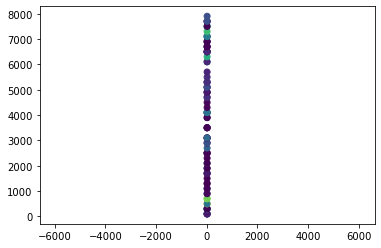

In [90]:
plt.scatter(df_new[:,0],df_new[:,1],c=df_new[:,4])
plt.axis('equal')

In [46]:
np.concatenate([random3_df[:,-1], random4_df[:,-1], random7_df[:,-1], random8_df[:,-1], random11_df[:,-1], random12_df[:,-1]])

array([5.78468397e-01, 8.32919040e-03, 3.76544056e-03, 5.73366733e-02,
       1.40576964e-02, 4.20429453e-02, 1.99330193e-01, 5.37894169e-02,
       1.79386169e-01, 4.10581713e-02, 2.22068718e-01, 4.46425770e-02,
       2.58202497e-01, 1.56498151e-02, 9.18939895e-02, 4.23947305e-01,
       4.54328584e-02, 2.87063070e-02, 4.19735718e-01, 5.79164411e-02,
       1.29344083e-01, 6.19217588e-02, 7.74067170e-02, 8.44618984e-02,
       9.09645906e-04, 2.10835222e-01, 4.25881067e-01, 7.40381289e-02,
       2.74931928e-02, 5.99129301e-03, 4.10199874e-02, 5.03905569e-02,
       8.79098644e-02, 8.13348449e-02, 8.61544081e-02, 5.43351186e-02,
       1.48523395e-01, 3.45083275e-02, 0.00000000e+00, 1.06764010e-01,
       1.37760158e-02, 3.39515111e-02, 3.73417639e-01, 2.26013201e-02,
       6.49263737e-02, 3.17425998e-01, 2.91819558e-01, 2.47360483e-02,
       8.93843748e-03, 3.74630246e-02, 6.30192740e-02, 2.29186850e-02,
       1.23774827e-01, 2.29619450e-01, 1.08528459e-01, 1.37120295e-01,
      

In [180]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
%cd C:\Users\heito\Desktop\Harvard\Sharad Lab\G1\Random_12
df_table=pd.read_csv('random_features_dipole.csv', delimiter=',')
#df_t=df_table.loc[df_table['seed'] == 12]
df=df_table.to_numpy()

f_matrix=df[:,0:-1]#np.vstack([random3_df[:,3:-1], random4_df[:,3:-1], random7_df[:,3:-1], random8_df[:,3:-1], random11_df[:,3:-1], random12_df[:,3:-1]])#, paired_df[:,2:-1]])
dip=df[:,-1]#np.concatenate([random3_df[:,-1], random4_df[:,-1], random7_df[:,-1], random8_df[:,-1], random11_df[:,-1], random12_df[:,-1]])#, paired_df[:,-1]])
#f_matrix_norm=f_matrix
dip[dip>1.2]=0
pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso(max_iter=2000))
])

search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0,1,0.001)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )
search.fit(f_matrix,dip)
print(search.best_params_)


coefficients = search.best_estimator_.named_steps['model'].coef_

importance = np.abs(coefficients)
print(importance)

C:\Users\heito\Desktop\Harvard\Sharad Lab\G1\Random_12
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
[CV 1/5] END .................model__alpha=0.0;, score=-0.014 total time=   0.0s
[CV 2/5] END .................model__alpha=0.0;, score=-0.027 total time=   0.0s
[CV 3/5] END .................model__alpha=0.0;, score=-0.029 total time=   0.0s
[CV 4/5] END .................model__alpha=0.0;, score=-0.025 total time=   0.0s
[CV 5/5] END .................model__alpha=0.0;, score=-0.011 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.001;, score=-0.014 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.001;, score=-0.028 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.001;, score=-0.029 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.001;, score=-0.025 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.001;, score=-0.011 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.002;, score=-0.013 total ti

C:\Users\heito\anaconda3\lib\site-packages\sklearn\pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.8857964925907, tolerance: 0.001415437019091201
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fi

[CV 3/5] END ...............model__alpha=0.011;, score=-0.030 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.011;, score=-0.025 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.011;, score=-0.010 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.012;, score=-0.013 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.012;, score=-0.029 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.012;, score=-0.031 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.012;, score=-0.025 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.012;, score=-0.010 total time=   0.0s
[CV 1/5] END model__alpha=0.013000000000000001;, score=-0.013 total time=   0.0s
[CV 2/5] END model__alpha=0.013000000000000001;, score=-0.029 total time=   0.0s
[CV 3/5] END model__alpha=0.013000000000000001;, score=-0.031 total time=   0.0s
[CV 4/5] END model__alpha=0.013000000000000001;, score=-0.025 total time=   0.0s
[CV 5/5] END model__alpha=0.

[CV 4/5] END ...............model__alpha=0.046;, score=-0.025 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.046;, score=-0.011 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.047;, score=-0.012 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.047;, score=-0.035 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.047;, score=-0.036 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.047;, score=-0.025 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.047;, score=-0.012 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.048;, score=-0.012 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.048;, score=-0.035 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.048;, score=-0.036 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.048;, score=-0.025 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.048;, score=-0.012 total time=   0.0s
[CV 1/5] END ...............

[CV 1/5] END ...............model__alpha=0.067;, score=-0.013 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.067;, score=-0.039 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.067;, score=-0.041 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.067;, score=-0.025 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.067;, score=-0.014 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.068;, score=-0.013 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.068;, score=-0.039 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.068;, score=-0.041 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.068;, score=-0.025 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.068;, score=-0.014 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.069;, score=-0.014 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.069;, score=-0.039 total time=   0.0s
[CV 3/5] END ...............

[CV 1/5] END .model__alpha=0.10300000000000001;, score=-0.015 total time=   0.0s
[CV 2/5] END .model__alpha=0.10300000000000001;, score=-0.040 total time=   0.0s
[CV 3/5] END .model__alpha=0.10300000000000001;, score=-0.043 total time=   0.0s
[CV 4/5] END .model__alpha=0.10300000000000001;, score=-0.026 total time=   0.0s
[CV 5/5] END .model__alpha=0.10300000000000001;, score=-0.016 total time=   0.0s
[CV 1/5] END .model__alpha=0.10400000000000001;, score=-0.015 total time=   0.0s
[CV 2/5] END .model__alpha=0.10400000000000001;, score=-0.040 total time=   0.0s
[CV 3/5] END .model__alpha=0.10400000000000001;, score=-0.043 total time=   0.0s
[CV 4/5] END .model__alpha=0.10400000000000001;, score=-0.026 total time=   0.0s
[CV 5/5] END .model__alpha=0.10400000000000001;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.105;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.105;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............

[CV 4/5] END ...............model__alpha=0.137;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.137;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.138;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.138;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.138;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.138;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.138;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.139;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.139;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.139;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.139;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.139;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............

[CV 3/5] END ...............model__alpha=0.167;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.167;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.167;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.168;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.168;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.168;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.168;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.168;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.169;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.169;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.169;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.169;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............

[CV 2/5] END ...............model__alpha=0.197;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.197;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.197;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.197;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.198;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.198;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.198;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.198;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.198;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.199;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.199;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.199;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............

[CV 5/5] END ...............model__alpha=0.228;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.229;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.229;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.229;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.229;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.229;, score=-0.016 total time=   0.0s
[CV 1/5] END ................model__alpha=0.23;, score=-0.015 total time=   0.0s
[CV 2/5] END ................model__alpha=0.23;, score=-0.040 total time=   0.0s
[CV 3/5] END ................model__alpha=0.23;, score=-0.043 total time=   0.0s
[CV 4/5] END ................model__alpha=0.23;, score=-0.026 total time=   0.0s
[CV 5/5] END ................model__alpha=0.23;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.231;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............

[CV 5/5] END ...............model__alpha=0.269;, score=-0.016 total time=   0.0s
[CV 1/5] END ................model__alpha=0.27;, score=-0.015 total time=   0.0s
[CV 2/5] END ................model__alpha=0.27;, score=-0.040 total time=   0.0s
[CV 3/5] END ................model__alpha=0.27;, score=-0.043 total time=   0.0s
[CV 4/5] END ................model__alpha=0.27;, score=-0.026 total time=   0.0s
[CV 5/5] END ................model__alpha=0.27;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.271;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.271;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.271;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.271;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.271;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.272;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............

[CV 5/5] END ...............model__alpha=0.296;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.297;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.297;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.297;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.297;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.297;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.298;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.298;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.298;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.298;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.298;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.299;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............

[CV 4/5] END ...............model__alpha=0.323;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.323;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.324;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.324;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.324;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.324;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.324;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.325;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.325;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.325;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.325;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.325;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............

[CV 2/5] END ...............model__alpha=0.355;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.355;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.355;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.355;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.356;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.356;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.356;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.356;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.356;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.357;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.357;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.357;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............

[CV 5/5] END ...............model__alpha=0.393;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.394;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.394;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.394;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.394;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.394;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.395;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.395;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.395;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.395;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.395;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.396;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............

[CV 5/5] END ................model__alpha=0.43;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.431;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.431;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.431;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.431;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.431;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.432;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.432;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.432;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.432;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.432;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.433;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............

[CV 5/5] END ...............model__alpha=0.451;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.452;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.452;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.452;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.452;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.452;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.453;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.453;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.453;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.453;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.453;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.454;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............

[CV 5/5] END .model__alpha=0.47200000000000003;, score=-0.016 total time=   0.0s
[CV 1/5] END .model__alpha=0.47300000000000003;, score=-0.015 total time=   0.0s
[CV 2/5] END .model__alpha=0.47300000000000003;, score=-0.040 total time=   0.0s
[CV 3/5] END .model__alpha=0.47300000000000003;, score=-0.043 total time=   0.0s
[CV 4/5] END .model__alpha=0.47300000000000003;, score=-0.026 total time=   0.0s
[CV 5/5] END .model__alpha=0.47300000000000003;, score=-0.016 total time=   0.0s
[CV 1/5] END .model__alpha=0.47400000000000003;, score=-0.015 total time=   0.0s
[CV 2/5] END .model__alpha=0.47400000000000003;, score=-0.040 total time=   0.0s
[CV 3/5] END .model__alpha=0.47400000000000003;, score=-0.043 total time=   0.0s
[CV 4/5] END .model__alpha=0.47400000000000003;, score=-0.026 total time=   0.0s
[CV 5/5] END .model__alpha=0.47400000000000003;, score=-0.016 total time=   0.0s
[CV 1/5] END .model__alpha=0.47500000000000003;, score=-0.015 total time=   0.0s
[CV 2/5] END .model__alpha=0

[CV 5/5] END ...............model__alpha=0.493;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.494;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.494;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.494;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.494;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.494;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.495;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.495;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.495;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.495;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.495;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.496;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............

[CV 3/5] END ...............model__alpha=0.534;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.534;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.534;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.535;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.535;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.535;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.535;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.535;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.536;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.536;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.536;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.536;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............

[CV 1/5] END ..model__alpha=0.5750000000000001;, score=-0.015 total time=   0.0s
[CV 2/5] END ..model__alpha=0.5750000000000001;, score=-0.040 total time=   0.0s
[CV 3/5] END ..model__alpha=0.5750000000000001;, score=-0.043 total time=   0.0s
[CV 4/5] END ..model__alpha=0.5750000000000001;, score=-0.026 total time=   0.0s
[CV 5/5] END ..model__alpha=0.5750000000000001;, score=-0.016 total time=   0.0s
[CV 1/5] END ..model__alpha=0.5760000000000001;, score=-0.015 total time=   0.0s
[CV 2/5] END ..model__alpha=0.5760000000000001;, score=-0.040 total time=   0.0s
[CV 3/5] END ..model__alpha=0.5760000000000001;, score=-0.043 total time=   0.0s
[CV 4/5] END ..model__alpha=0.5760000000000001;, score=-0.026 total time=   0.0s
[CV 5/5] END ..model__alpha=0.5760000000000001;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.577;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.577;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............

[CV 3/5] END ...............model__alpha=0.613;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.613;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.613;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.614;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.614;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.614;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.614;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.614;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.615;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.615;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.615;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.615;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............

[CV 4/5] END ...............model__alpha=0.647;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.647;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.648;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.648;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.648;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.648;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.648;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.649;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.649;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.649;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.649;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.649;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............

[CV 4/5] END ...............model__alpha=0.683;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.683;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.684;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.684;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.684;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.684;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.684;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.685;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.685;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.685;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.685;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.685;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............

[CV 4/5] END ...............model__alpha=0.723;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.723;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.724;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.724;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.724;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.724;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.724;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.725;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.725;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.725;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.725;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.725;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............

[CV 3/5] END ...............model__alpha=0.763;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.763;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.763;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.764;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.764;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.764;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.764;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.764;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.765;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.765;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.765;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.765;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............

[CV 2/5] END ...............model__alpha=0.798;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.798;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.798;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.798;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.799;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.799;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.799;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.799;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.799;, score=-0.016 total time=   0.0s
[CV 1/5] END .................model__alpha=0.8;, score=-0.015 total time=   0.0s
[CV 2/5] END .................model__alpha=0.8;, score=-0.040 total time=   0.0s
[CV 3/5] END .................model__alpha=0.8;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............

[CV 3/5] END ..model__alpha=0.8230000000000001;, score=-0.043 total time=   0.0s
[CV 4/5] END ..model__alpha=0.8230000000000001;, score=-0.026 total time=   0.0s
[CV 5/5] END ..model__alpha=0.8230000000000001;, score=-0.016 total time=   0.0s
[CV 1/5] END ..model__alpha=0.8240000000000001;, score=-0.015 total time=   0.0s
[CV 2/5] END ..model__alpha=0.8240000000000001;, score=-0.040 total time=   0.0s
[CV 3/5] END ..model__alpha=0.8240000000000001;, score=-0.043 total time=   0.0s
[CV 4/5] END ..model__alpha=0.8240000000000001;, score=-0.026 total time=   0.0s
[CV 5/5] END ..model__alpha=0.8240000000000001;, score=-0.016 total time=   0.0s
[CV 1/5] END ..model__alpha=0.8250000000000001;, score=-0.015 total time=   0.0s
[CV 2/5] END ..model__alpha=0.8250000000000001;, score=-0.040 total time=   0.0s
[CV 3/5] END ..model__alpha=0.8250000000000001;, score=-0.043 total time=   0.0s
[CV 4/5] END ..model__alpha=0.8250000000000001;, score=-0.026 total time=   0.0s
[CV 5/5] END ..model__alpha=

[CV 5/5] END ................model__alpha=0.86;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.861;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.861;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.861;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.861;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.861;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.862;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.862;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.862;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.862;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.862;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.863;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............

[CV 2/5] END ...............model__alpha=0.881;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.881;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.881;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.881;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.882;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.882;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.882;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.882;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.882;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.883;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.883;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.883;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............

[CV 4/5] END ...............model__alpha=0.915;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.915;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.916;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.916;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.916;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.916;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.916;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.917;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.917;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.917;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.917;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.917;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............

[CV 1/5] END ..model__alpha=0.9470000000000001;, score=-0.015 total time=   0.0s
[CV 2/5] END ..model__alpha=0.9470000000000001;, score=-0.040 total time=   0.0s
[CV 3/5] END ..model__alpha=0.9470000000000001;, score=-0.043 total time=   0.0s
[CV 4/5] END ..model__alpha=0.9470000000000001;, score=-0.026 total time=   0.0s
[CV 5/5] END ..model__alpha=0.9470000000000001;, score=-0.016 total time=   0.0s
[CV 1/5] END ..model__alpha=0.9480000000000001;, score=-0.015 total time=   0.0s
[CV 2/5] END ..model__alpha=0.9480000000000001;, score=-0.040 total time=   0.0s
[CV 3/5] END ..model__alpha=0.9480000000000001;, score=-0.043 total time=   0.0s
[CV 4/5] END ..model__alpha=0.9480000000000001;, score=-0.026 total time=   0.0s
[CV 5/5] END ..model__alpha=0.9480000000000001;, score=-0.016 total time=   0.0s
[CV 1/5] END ..model__alpha=0.9490000000000001;, score=-0.015 total time=   0.0s
[CV 2/5] END ..model__alpha=0.9490000000000001;, score=-0.040 total time=   0.0s
[CV 3/5] END ..model__alpha=

[CV 2/5] END ...............model__alpha=0.978;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.978;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.978;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.978;, score=-0.016 total time=   0.0s
[CV 1/5] END ...............model__alpha=0.979;, score=-0.015 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.979;, score=-0.040 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.979;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.979;, score=-0.026 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.979;, score=-0.016 total time=   0.0s
[CV 1/5] END ................model__alpha=0.98;, score=-0.015 total time=   0.0s
[CV 2/5] END ................model__alpha=0.98;, score=-0.040 total time=   0.0s
[CV 3/5] END ................model__alpha=0.98;, score=-0.043 total time=   0.0s
[CV 4/5] END ...............

In [191]:
np.shape(y)

(568,)

In [308]:

from sklearn.linear_model import LinearRegression
x = np.transpose(np.vstack([f_matrix[:,0],f_matrix[:,4]]))

y =dip[:]
#fit=np.polyfit(x, y, 1)
#p = np.poly1d(fit)
xp = np.linspace(5000, 25000)

reg = LinearRegression().fit(x, y)
#reg.score(X, y)

print(reg.coef_)
#plt.plot(x, y, '.', xp, p(xp), '-')

print(reg.intercept_)
#print(reg.score(X, y))

[2.27828701e-05 3.47963462e-04]
-0.14675008803190104


{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


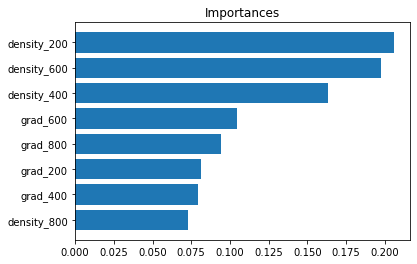

In [181]:
from sklearn.ensemble import RandomForestRegressor
col_names=[ 'density_200', 'density_400', 'density_600', 'density_800', 'grad_200', 'grad_400', 'grad_600', 'grad_800']
model=RandomForestRegressor()
model.fit(f_matrix,dip)
print(model.get_params())
importances=model.feature_importances_
idxs=np.argsort(importances)
plt.title('Importances')
plt.barh(range(len(idxs)),importances[idxs],align='center')
plt.yticks(range(len(idxs)),[col_names[i] for i in idxs])
plt.show()

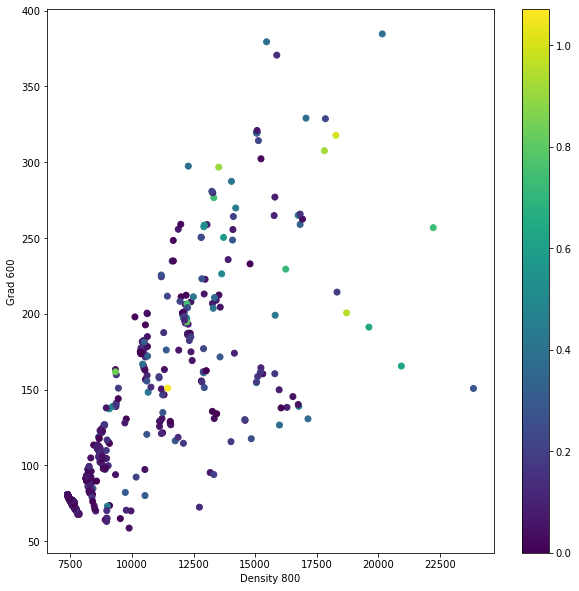

In [309]:
fig = plt.figure(figsize=[10,10])
#ax = fig.add_subplot(111, projection='3d')

cm = plt.cm.get_cmap('viridis')
color=dip[:]
color[color>2]=2

sc=plt.scatter(f_matrix[:,0],f_matrix[:,4],c=color,cmap=cm)
plt.xlabel("Density 800")
plt.ylabel("Grad 600")
#x=np.linspace(5000,7500)
#y=(-5.05973655e+01*x+ 0.14675008803190104)
#plt.plot(x,y)
#2.27828701e-05*feats[:,1] + 3.47963462e-04*feats[:,0] -0.14675008803190104
#ax.scatter(sim_matrix[:,1],sim_matrix[:,4],sim_matrix[:,10],c='r')
plt.colorbar(sc)
plt.draw()

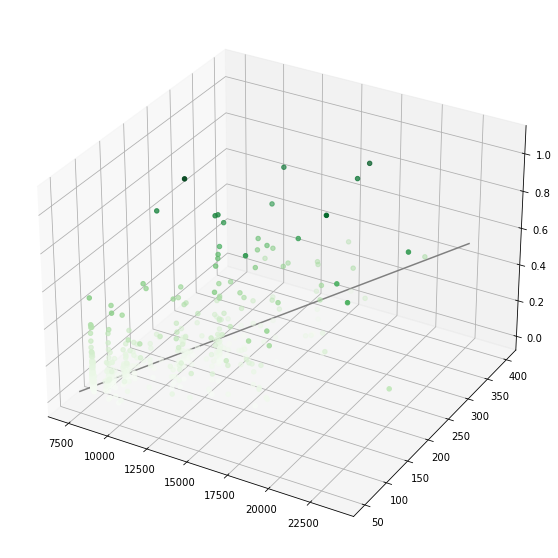

In [313]:
fig = plt.figure(figsize=[10,10])
ax = plt.axes(projection='3d')

# Data for a three-dimensional line

xline = np.linspace(7500, 22500, 2000)
yline = np.linspace(50, 400, 2000)
zline = 2.27828701e-05*xline + 3.47963462e-04*yline -0.14675008803190104
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = dip
xdata = f_matrix[:,0]
ydata = f_matrix[:,4]
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');

In [104]:
print(np.shape(paired_df[:,:]))

(351, 15)


In [107]:
new_df=paired_df#np.vstack([random3_df[:,:], random4_df[:,:], random7_df[:,:], random8_df[:,:], random11_df[:,:], random12_df[:,:]])
col_names=[ 'design_x', 'design_y', 'grad200' , 'density200', 'lap200', 'grad400', 'density400', 'lap400', 'grad600', 'density600', 'lap600', 'grad800', 'density800', 'lap800','dipole']
pand = pd.DataFrame(new_df, columns = col_names)

pand.to_csv('paired_features_dipole_v2.csv', encoding='utf-8', index=False)

In [92]:
f_matrix=df_new[:,2:-1]
dip=df_new[:,-1]
f_matrix_norm=f_matrix
for ii in range(np.size(f_matrix,1)):
    if np.std(f_matrix[:,ii]) >0:
        
        f_matrix_norm[:,ii]=(f_matrix[:,ii]-np.mean(f_matrix[:,ii]))/np.std(f_matrix[:,ii])
    else:
        print(ii)
        f_matrix_norm[:,ii]=(f_matrix[:,ii]-np.mean(f_matrix[:,ii]))/1
dip_norm=(dip[:]-np.mean(dip[:]))/np.std(dip[:])
model = linear_model.Lasso()
# define model evaluation method
cv = model_selection.RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.01)
# define search
search = model_selection.GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(f_matrix_norm, dip)
print(results.best_params_) 

{'alpha': 0.02}


In [93]:
clf = linear_model.Lasso(alpha=0.02)
clf.fit(f_matrix_norm, dip_norm)
print(clf.coef_)

[ 0.09290819  0.          0.          0.          0.          0.7906632
  0.         -0.        ]


In [100]:
np.mean((f_matrix_norm[:,5]*0.79-dip_norm[:])**2)

0.6891525164416382

--- 0.02081465721130371 seconds ---


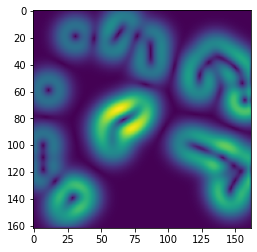

In [64]:
sigma=8
start_time = time.time()
im_blur = ndimage.gaussian_filter(im, sigma=sigma, mode='constant',cval=0)
im_blur_norm=im_blur*sigma*np.sqrt(np.pi)

im_sx = ndimage.sobel(im_blur_norm, axis=1, mode='reflect')
im_sy = ndimage.sobel(im_blur_norm, axis=0, mode='reflect')
im_sobel=np.hypot(im_sx, im_sy)
print("--- %s seconds ---" % (time.time() - start_time))
plt.imshow(im_sobel)

In [ ]:
#gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
# Find Canny edges
sigma=400
im_8=np.uint8(im)
edged = cv2.Canny(im_8, 30, 200)
contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
im_blur = ndimage.gaussian_filter(im, sigma=sigma, mode='constant',cval=0)
#im_blur=cv2.GaussianBlur(im,(4*sigma+1,4*sigma+1),sigma,sigma, borderType=cv2.BORDER_CONSTANT)
im_blur_norm=im_blur*sigma*np.sqrt(np.pi)

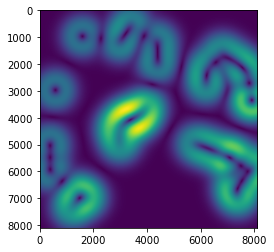

In [57]:
plt.imshow(im_blur_norm)
im_sx = ndimage.sobel(im_blur_norm, axis=1, mode='reflect')
im_sy = ndimage.sobel(im_blur_norm, axis=0, mode='reflect')
im_sobel=np.hypot(im_sx, im_sy)
#im_sobel=np.uint64(im_sobel)
#im_lap=ndimage.gaussian_laplace(im, sigma, mode='reflect')
#im_lap_norm=im_lap*sigma*np.sqrt(np.pi)
#sobelxy = cv2.Sobel(src=im_blur_norm, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=31,borderType=cv2.BORDER_CONSTANT)
plt.imshow(im_sobel)

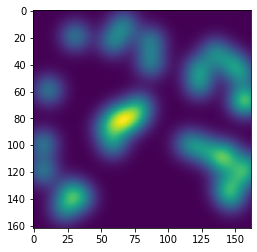

In [65]:
plt.imshow(im_blur_norm)